In [2]:
import pandas as pd

applications = pd.read_csv('applications.csv')
interviews = pd.read_csv('interviews.csv')
feedback = pd.read_csv('feedback.csv')
jobs = pd.read_csv('jobs.csv')
job_required_skills = pd.read_csv('job_required_skills.csv')
candidates = pd.read_csv('candidates.csv')
skills = pd.read_csv('skills.csv')


In [3]:
print("Applications sample:")
print(applications.head())

print("\nInterviews sample:")
print(interviews.head())

print("\nFeedback sample:")
print(feedback.head())

print("\nJobs sample:")
print(jobs.head())

print("\nJob Required Skills sample:")
print(job_required_skills.head())

print("\nCandidates sample:")
print(candidates.head())

print("\nSkills sample:")
print(skills.head())


Applications sample:
  ApplicationID CandidateID JobID ApplicationDate       Status        Source  \
0         A1001       C0001  J049      2025-01-03  Interviewed    Job Portal   
1         A1002       C0001  J018      2024-06-03      Offered    Job Portal   
2         A1003       C0001  J012      2024-11-10      Offered      Referral   
3         A1004       C0001  J046      2024-02-23  Interviewed  Careers Site   
4         A1005       C0002  J048      2024-07-01     Rejected    Job Portal   

   ResumeMatch  
0           45  
1           55  
2           86  
3           60  
4           56  

Interviews sample:
  InterviewID ApplicationID      Round InterviewDate     Interviewer  \
0       I2001         A1001  Screening    2025-01-08  Interviewer_30   
1       I2002         A1001  Technical    2025-01-12   Interviewer_4   
2       I2003         A1001         HR    2025-01-17   Interviewer_3   
3       I2004         A1002  Technical    2024-07-01  Interviewer_16   
4       I2005   

In [4]:
applications = pd.read_csv('applications.csv')


In [5]:
# Aggregate interviews
intv_agg = interviews.groupby('ApplicationID').agg({
    'RatingCommunication': 'mean',
    'RatingProblemSolving': 'mean',
    'RatingCultureFit': 'mean',
    'OverallRating': 'mean',
    'InterviewID': 'count'
}).reset_index().rename(columns={'InterviewID': 'NumInterviews'})

# Aggregate feedback sentiment
fb_intv = pd.merge(feedback, interviews[['InterviewID', 'ApplicationID']], on='InterviewID')
fb_agg = fb_intv.groupby('ApplicationID').agg({
    'SentimentScore': 'mean',
    'FeedbackID': 'count'
}).reset_index().rename(columns={'SentimentScore': 'AvgSentiment', 'FeedbackID': 'NumFeedbacks'})

# Merge into applications DataFrame
merged = applications.merge(intv_agg, on='ApplicationID', how='left').merge(fb_agg, on='ApplicationID', how='left')

# Add job info columns from jobs DataFrame
merged = merged.merge(jobs[['JobID', 'Department', 'MinExperience']], on='JobID', how='left')


In [6]:
print(merged.columns.tolist())


['ApplicationID', 'CandidateID', 'JobID', 'ApplicationDate', 'Status', 'Source', 'ResumeMatch', 'RatingCommunication', 'RatingProblemSolving', 'RatingCultureFit', 'OverallRating', 'NumInterviews', 'AvgSentiment', 'NumFeedbacks', 'Department', 'MinExperience']


In [7]:
for col in ['RatingCommunication', 'RatingProblemSolving', 'RatingCultureFit', 'OverallRating', 'AvgSentiment']:
    merged[col] = merged[col].fillna(merged[col].mean())


In [8]:
merged['TargetHired'] = merged['Status'].apply(lambda x: 1 if x in ['Hired', 'Offered'] else 0)


In [9]:
for col in ['RatingCommunication', 'RatingProblemSolving', 'RatingCultureFit', 'OverallRating', 'AvgSentiment']:
    merged[col] = merged[col].fillna(merged[col].mean())


In [10]:
merged = pd.get_dummies(merged, columns=['Department'], drop_first=True)


In [11]:
feature_cols = ['RatingCommunication', 'RatingProblemSolving', 'RatingCultureFit', 'OverallRating', 'AvgSentiment', 'ResumeMatch', 'MinExperience'] + \
               [col for col in merged.columns if col.startswith('Department_')]

X = merged[feature_cols]
y = merged['TargetHired']


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize model
model = LogisticRegression(max_iter=1000)

# Train model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.91792656587473

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       425
           1       0.00      0.00      0.00        38

    accuracy                           0.92       463
   macro avg       0.46      0.50      0.48       463
weighted avg       0.84      0.92      0.88       463


Confusion Matrix:
 [[425   0]
 [ 38   0]]


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
import joblib

joblib.dump(model, 'hiring_prediction_model.pkl')


['hiring_prediction_model.pkl']

In [15]:
# Predict probabilities of hire for all data
merged['HireProbability'] = model.predict_proba(X)[:, 1]

# Predict hire class (0 or 1)
merged['HirePrediction'] = model.predict(X)


In [16]:
merged.to_csv('applications_with_predictions.csv', index=False)


In [17]:
print(merged.head())


  ApplicationID CandidateID JobID ApplicationDate       Status        Source  \
0         A1001       C0001  J049      2025-01-03  Interviewed    Job Portal   
1         A1002       C0001  J018      2024-06-03      Offered    Job Portal   
2         A1003       C0001  J012      2024-11-10      Offered      Referral   
3         A1004       C0001  J046      2024-02-23  Interviewed  Careers Site   
4         A1005       C0002  J048      2024-07-01     Rejected    Job Portal   

   ResumeMatch  RatingCommunication  RatingProblemSolving  RatingCultureFit  \
0           45                2.000              3.666667          2.666667   
1           55                4.000              4.000000          3.000000   
2           86                4.500              4.000000          4.000000   
3           60                2.000              3.500000          2.500000   
4           56                3.123              3.349794          2.964335   

   ...  Department_General  Department_HR  D

In [18]:
# Export CSV WITHOUT index, in standard UTF-8, and commas as separator
merged.to_csv('applications_with_predictions.csv', index=False, encoding='utf-8')


In [19]:
merged['TargetHired'] = merged['Status'].apply(lambda x: 1 if x in ['Hired', 'Offered'] else 0)


In [20]:
for col in ['RatingCommunication', 'RatingProblemSolving', 'RatingCultureFit', 'OverallRating', 'AvgSentiment']:
    merged[col] = merged[col].fillna(merged[col].mean())


In [21]:
print(merged.columns.tolist())


['ApplicationID', 'CandidateID', 'JobID', 'ApplicationDate', 'Status', 'Source', 'ResumeMatch', 'RatingCommunication', 'RatingProblemSolving', 'RatingCultureFit', 'OverallRating', 'NumInterviews', 'AvgSentiment', 'NumFeedbacks', 'MinExperience', 'TargetHired', 'Department_Clinical', 'Department_Design', 'Department_Engineering', 'Department_General', 'Department_HR', 'Department_IT', 'Department_PMO', 'Department_Product', 'Department_R&D', 'Department_SalesOps', 'Department_Security', 'HireProbability', 'HirePrediction']


In [22]:
feature_cols = [
    'RatingCommunication',
    'RatingProblemSolving',
    'RatingCultureFit',
    'OverallRating',
    'AvgSentiment',
    'ResumeMatch',
    'MinExperience'
] + [col for col in merged.columns if col.startswith('Department_')]

X = merged[feature_cols]
y = merged['TargetHired']


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.91792656587473

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       425
           1       0.00      0.00      0.00        38

    accuracy                           0.92       463
   macro avg       0.46      0.50      0.48       463
weighted avg       0.84      0.92      0.88       463


Confusion Matrix:
 [[425   0]
 [ 38   0]]


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
# Predict hire probability and class for all data points
merged['HireProbability'] = model.predict_proba(X)[:, 1]
merged['HirePrediction'] = model.predict(X)


In [33]:
import os
print(os.getcwd())


C:\Users\anula biju\Project


In [36]:
merged.to_csv(r'C:\Users\anula biju\Downloads\HR-Interview-Dashboard\data\applications_with_predictions.csv', index=False, encoding='utf-8')


In [32]:
merged.to_csv('applications_with_predictions.csv', index=False, encoding='utf-8')


In [25]:
merged.to_csv('applications_with_predictions.csv', index=False, encoding='utf-8')


In [26]:
merged.to_csv(r'C:\Users\anula biju\Downloads\HR-Interview-Dashboard\data\applications_with_predictions.csv', index=False, encoding='utf-8')


In [27]:
print(merged['TargetHired'].value_counts())


TargetHired
0    2159
1     154
Name: count, dtype: int64


In [28]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Assuming you have your features X and target y as follows:
# X = merged[feature_cols]
# y = merged['TargetHired']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data only
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check new class balance
print(y_train_res.value_counts())

# Train your model on balanced data
model = LogisticRegression(max_iter=1000)
model.fit(X_train_res, y_train_res)

# Predict and evaluate as usual
y_pred = model.predict(X_test)


C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

TargetHired
0    1734
1    1734
Name: count, dtype: int64


In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.6889848812095032
              precision    recall  f1-score   support

           0       0.93      0.72      0.81       425
           1       0.10      0.37      0.16        38

    accuracy                           0.69       463
   macro avg       0.52      0.54      0.49       463
weighted avg       0.86      0.69      0.76       463

[[305 120]
 [ 24  14]]


In [30]:
merged['HireProbability'] = model.predict_proba(X)[:, 1]
merged['HirePrediction'] = model.predict(X)


In [46]:
merged.to_csv('applications_with_predictions_smote.csv', index=False, encoding='utf-8')


In [31]:
# Export updated predictions CSV to specific folder path
merged.to_csv(r'C:\Users\anula biju\Downloads\HR-Interview-Dashboard\data\applications_with_predictions_smote.csv', index=False, encoding='utf-8')


In [33]:
y_true = merged['TargetHired']  # Actual hiring labels
y_pred = merged['HirePrediction']  # Your model's predicted labels


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Print full classification metrics
print(classification_report(y_true, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Optional: Print overall accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))


              precision    recall  f1-score   support

           0       0.94      0.71      0.81      2159
           1       0.08      0.38      0.14       154

    accuracy                           0.69      2313
   macro avg       0.51      0.54      0.47      2313
weighted avg       0.88      0.69      0.76      2313

Confusion Matrix:
 [[1527  632]
 [  96   58]]
Accuracy: 68.53%


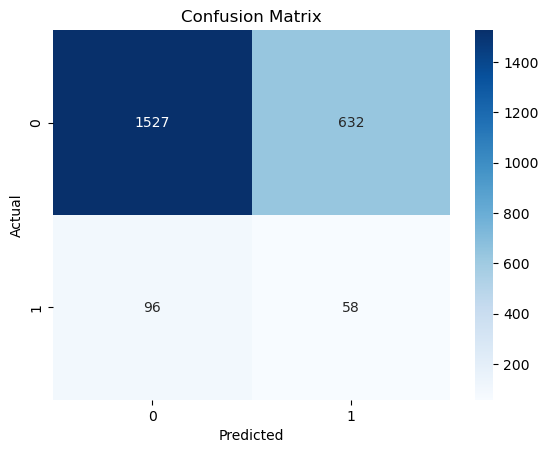

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [37]:
import pandas as pd
from sklearn.metrics import classification_report

# Get classification report as a dictionary
report_dict = classification_report(y_true, y_pred, output_dict=True)

# Convert to DataFrame for easy export
report_df = pd.DataFrame(report_dict).transpose()

print(report_df)


              precision    recall  f1-score      support
0              0.940850  0.707272  0.807509  2159.000000
1              0.084058  0.376623  0.137441   154.000000
accuracy       0.685257  0.685257  0.685257     0.685257
macro avg      0.512454  0.541948  0.472475  2313.000000
weighted avg   0.883805  0.685257  0.762896  2313.000000


In [38]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

print(cm_df)


          Predicted 0  Predicted 1
Actual 0         1527          632
Actual 1           96           58


In [39]:
report_df.to_csv('classification_report.csv', index=True)
cm_df.to_csv('confusion_matrix.csv', index=True)


In [40]:
# Save confusion matrix CSV
cm_df.to_csv(r'C:\Users\anula biju\Downloads\HR-Interview-Dashboard\data\confusion_matrix.csv', index=True, encoding='utf-8')

# Save classification report CSV
report_df.to_csv(r'C:\Users\anula biju\Downloads\HR-Interview-Dashboard\data\classification_report.csv', index=True, encoding='utf-8')
